# Logistic Regression Model

### Dataset Information
No. of Features: 12  
No. of Instances: 4492  

### Table of Contents<a name='table of contents'></a>

1. [Data Ingestion](#data ingestion)
2. [Features & Target Arrays](#features and target arrays)
3. [Logistic Regression Model](#logreg)
4. [Hyperparameter Tuning](#hyperparameter tuning)  
    a. [Classification Report](#classification report)  
    b. [Confusion Matrix](#confusion matrix)   
    c. [Class Balance Plot](#class balance)
4. [Save Model](#pickle)

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick as yb
sns.set_palette('RdBu', 10)

## Data Ingestion<a name='data ingestion'></a>

In [2]:
URL = 'https://raw.githubusercontent.com/georgetown-analytics/classroom-occupancy/master/models/sensor_data_ml.csv'

def fetch_data(fname='sensor_data_ml.csv'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
DATA = fetch_data()

In [2]:
# Import as pandas dataframe with DateTimeIndex: df
df = pd.read_csv('sensor_data_ml.csv', index_col='datetime', parse_dates=True)

In [3]:
# Rename columns
df.columns = ['temp', 'humidity', 'co2', 'light', 'light_st', 'noise',
              'bluetooth', 'images', 'door', 'occupancy_count', 'occupancy_level']

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4492 entries, 2017-03-25 09:05:00 to 2017-06-10 16:47:00
Data columns (total 11 columns):
temp               4492 non-null float64
humidity           4492 non-null float64
co2                4492 non-null float64
light              4492 non-null float64
light_st           4492 non-null float64
noise              4492 non-null float64
bluetooth          4492 non-null float64
images             4492 non-null float64
door               4492 non-null float64
occupancy_count    4492 non-null float64
occupancy_level    4492 non-null object
dtypes: float64(10), object(1)
memory usage: 421.1+ KB


,temp,humidity,co2,light,light_st,noise,bluetooth,images,door,occupancy_count,occupancy_level
datetime,,,,,,,,,,,
2017-03-25 09:05:00,22.600000,36.900000,781.000000,430.000000,1.0,511.000000,1.000000,15.242697,0.000000,0.000000,empty
2017-03-25 09:06:00,23.800000,38.954167,765.465279,428.533744,1.0,503.515931,11.399457,15.242697,0.000000,0.000000,empty
2017-03-25 09:07:00,23.850000,38.900000,768.458333,423.576500,1.0,510.548913,19.916667,15.242697,0.083333,4.416667,low
2017-03-25 09:08:00,23.900000,38.766667,777.791667,423.053571,1.0,506.504630,29.750000,15.242697,0.000000,23.416667,mid-level
2017-03-25 09:09:00,23.908333,38.733333,770.864583,438.607904,1.0,500.092672,35.860577,15.242697,0.000000,30.000000,high


## Features & Target Arrays<a name='features and target arrays'></a>

In [6]:
# Breakdown of classroom occupancy levels
df.occupancy_level.value_counts()

high         2881
mid-level     781
empty         482
low           348
Name: occupancy_level, dtype: int64

In [4]:
# Encode multiclass target variable
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit_transform(df['occupancy_level'])

array([0, 0, 2, ..., 2, 2, 2], dtype=int64)

In [5]:
X = df.drop('occupancy_level', axis=1).values
y = df['occupancy_level']

In [7]:
# Use TimeSeriesSplit to create training and test set split indices
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## LogisticRegression Model<a name='logreg'></a>

In [8]:
# Initial cross-validation scores
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Fit logistic regression classifier onto the training data: logreg
logreg = LogisticRegression().fit(X_train, y_train)

# Print the 12-fold cross-validation scores
cv_scores = cross_val_score(logreg, X_train, y_train, cv=tscv)

print('Logistic Regression Cross-Validation Scores')
print(cv_scores)
print('Average 12-Fold CV Score: {:.4f}'.format(np.mean(cv_scores)))

Logistic Regression Cross-Validation Scores
[ 0.85579937  0.87147335  0.92789969  0.84012539  0.81504702  0.7492163
  0.54858934  0.96551724  0.80250784  0.73040752  0.65830721  0.9153605 ]
Average 12-Fold CV Score: 0.8067


In [9]:
# Initial classification report
from sklearn.metrics import classification_report

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute and print the classification report and training and test scores
print('Logistic Regression Model')
print(classification_report(y_test, y_pred))
print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Logistic Regression Model
             precision    recall  f1-score   support

      empty       1.00      1.00      1.00        61
       high       0.94      1.00      0.97       198
        low       0.85      1.00      0.92        41
  mid-level       1.00      0.56      0.71        45

avg / total       0.95      0.94      0.94       345

Training set score: 0.9127
Test set score: 0.9420


### Hyperparameter Tuning<a name='hyperparameter tuning'></a>

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100, 110, 120], 'class_weight':[None, 'balanced']}

grid = GridSearchCV(LogisticRegression(), param_grid, cv=tscv)

logreg_clf = grid.fit(X_train, y_train)

print('Best estimator:\n{}'.format(logreg_clf.best_estimator_))

Best estimator:
LogisticRegression(C=110, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [12]:
print('Logistic Regression Model')
print('Best Score: {:.4f}'.format(logreg_clf.best_score_))
print('Best parameters: {}'.format(logreg_clf.best_params_))

Logistic Regression Model
Best Score: 0.8858
Best parameters: {'C': 110, 'class_weight': 'balanced'}


In [13]:
# Accuracy scores after tuning C parameter

# Predict the labels of the test set: y_pred
y_pred = logreg_clf.predict(X_test)

print('Training set score: {:.4f}'.format(logreg_clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(logreg_clf.score(X_test, y_test)))

Training set score: 0.9510
Test set score: 0.9565


### Classification Report<a name='classification report'></a>

In [22]:
# Compute and print the classification report and training and test scores
print('Logistic Regression Model')
print(classification_report(y_test, y_pred))

Logistic Regression Model
             precision    recall  f1-score   support

      empty       1.00      1.00      1.00        61
       high       0.99      1.00      0.99       198
        low       0.76      1.00      0.86        41
  mid-level       1.00      0.67      0.80        45

avg / total       0.97      0.96      0.95       345



In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score

print('Logistic Regression F1 Scores')
print('F1 Score - micro: {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('F1 Score - weighted: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('F1 Score - macro: {:.4f}'.format(f1_score(y_test, y_pred, average='macro')))

Logistic Regression F1 Scores
F1 Score - micro: 0.9565
F1 Score - weighted: 0.9548
F1 Score - macro: 0.9145


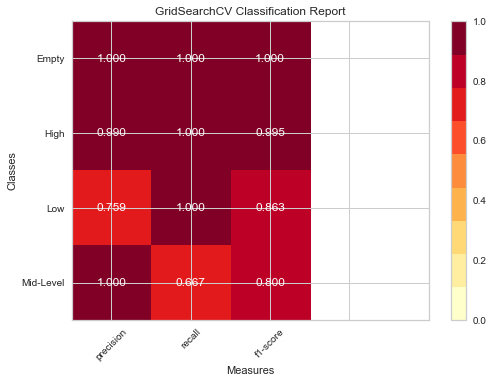

In [17]:
from yellowbrick.classifier import ClassificationReport
classes = ['Empty', 'High', 'Low', 'Mid-Level']

fig = plt.figure()
visualizer = ClassificationReport(logreg_clf, classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
fig.savefig('ml_graphs/logreg_classification_report.png')

### Confusion Matrix <a name='confusion matrix'></a>

In [18]:
from sklearn.metrics import confusion_matrix

print('Logistic Regression Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

Logistic Regression Confusion Matrix
[[ 61   0   0   0]
 [  0 198   0   0]
 [  0   0  41   0]
 [  0   2  13  30]]


### Class Balance Plot<a name='class balance'></a>

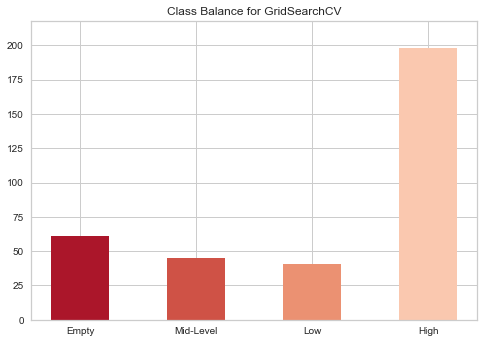

In [19]:
from yellowbrick.classifier import ClassBalance
classes = ['Empty', 'High', 'Low', 'Mid-Level']

visualizer = ClassBalance(logreg_clf, classes=classes)

fig = plt.figure()
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
fig.savefig('ml_graphs/logreg_class_balance.png')

## Save Model<a name='pickle'></a>

In [20]:
import pickle

logreg_model = 'logreg_model.sav'

# Save fitted model to disk
pickle.dump(logreg_clf, open(logreg_model, 'wb'))

### [Return to Table of Contents](#table of contents)

In [21]:
# Test model
loaded_model = pickle.load(open(logreg_model, 'rb'))

result = loaded_model.score(X_test, y_test)
print(result)

0.95652173913
